<a href="https://colab.research.google.com/github/dsmlraghu/Cover_simulation/blob/main/Torsional_spring_calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter shape (R=Rectangular / S=Square / T=Triangular): S
Enter Length (mm): 800
Enter Breadth (mm) — Enter 0 if square: 0
Enter Weight of the cover (kg): 65
Enter Inner Diameter of spring (mm) [shaft diameter]: 24
Enter Wire Diameter (mm): 10
Enter Material Density (kg/m³) [default 7850]: 7850
Enter Modulus of Elasticity (MPa) [default 200000]: 196000
Enter Poisson's ratio [default 0.3]: 0.28
Enter Admissible Stress (MPa) [default 690]: 590

--- SPRING DESIGN RESULTS (Each of 2 Springs) ---


,Spring Parameters
Torque per Spring (Nm),79.70625
Torque with SF (Nm),119.559375
Wire Diameter (mm),10.0
Inner Diameter (mm),24.0
Outer Diameter (mm),44.0
Mean Coil Diameter (mm),34.0
Number of Coils,5
Modulus of Elasticity (MPa),196000.0
Modulus of Rigidity (MPa),76562.5
Spring Length (mm),50.0



--- TORQUE and STRESS vs ANGLE ---


,Angle (deg),Torque (Nm),Stress (MPa)
0,0.000000,0.000000,0.000000
1,1.530612,11.140020,3.858025
2,3.061224,22.280040,7.716049
3,4.591837,33.420061,11.574074
4,6.122449,44.560081,15.432099


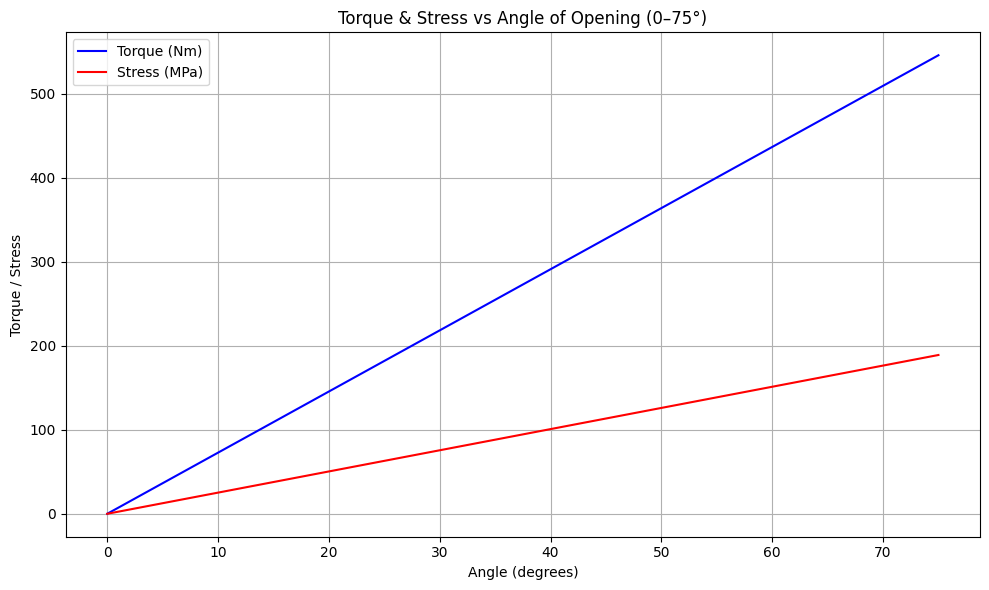


✅ Excel file saved as 'spring_design_output.xlsx'
Spring mounting diagram not found.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

# === USER INPUT ===
shape_input = input("Enter shape (R=Rectangular / S=Square / T=Triangular): ").strip().upper()
shape_map = {'R': 'rectangular', 'S': 'square', 'T': 'triangular'}
shape = shape_map.get(shape_input)
if not shape:
    raise ValueError("Invalid shape selection. Use R, S, or T.")

length_mm = float(input("Enter Length (mm): "))
breadth_mm = float(input("Enter Breadth (mm) — Enter 0 if square: "))
weight_kg = float(input("Enter Weight of the cover (kg): "))
weight_N = weight_kg * 9.81

inner_diameter_mm = float(input("Enter Inner Diameter of spring (mm) [shaft diameter]: "))
wire_diameter_mm = float(input("Enter Wire Diameter (mm): "))

density = float(input("Enter Material Density (kg/m³) [default 7850]: ") or 7850)
E_input = float(input("Enter Modulus of Elasticity (MPa) [default 200000]: ") or 200000)
poisson_ratio = float(input("Enter Poisson's ratio [default 0.3]: ") or 0.3)
admissible_stress = float(input("Enter Admissible Stress (MPa) [default 690]: ") or 690)

# === UNIT CONVERSIONS ===
E = E_input * 1e6
G = E / (2 * (1 + poisson_ratio))
ID = inner_diameter_mm / 1000
d_wire = wire_diameter_mm / 1000
OD = ID + 2 * d_wire
D_mean = ID + d_wire

# === SPRING DESIGN FUNCTION ===
def design_spring_iterative(shape, length_mm, breadth_mm, weight_N, density, G, admissible_stress, D_mean, d_wire, ID, OD):
    lever_arm = 0.25  # assumed horizontal distance from hinge to CG
    total_torque = weight_N * lever_arm
    torque = total_torque / 2  # each spring shares half the torque
    torque_safe = torque * 1.5  # apply safety factor

    n_coils = 5
    stress = float('inf')
    warning_msgs = []

    while stress > admissible_stress * 1e6:
        k = (G * d_wire**4) / (10.8 * D_mean * n_coils)
        stress = (32 * torque_safe * D_mean) / (np.pi * d_wire**3)

        if n_coils > 50:
            warning_msgs.append("❌ Number of coils exceeded 50.")
            break

        if stress > admissible_stress * 1e6:
            n_coils += 1

    deflection_rad = torque_safe / k
    deflection_deg = np.degrees(deflection_rad)
    energy = 0.5 * torque_safe * deflection_rad

    angles_rad = np.linspace(0, np.radians(75), 50)
    torques = k * angles_rad
    stresses = (32 * torques * D_mean) / (np.pi * d_wire**3) / 1e6  # MPa

    result = {
        "Torque per Spring (Nm)": torque,
        "Torque with SF (Nm)": torque_safe,
        "Wire Diameter (mm)": d_wire * 1000,
        "Inner Diameter (mm)": ID * 1000,
        "Outer Diameter (mm)": OD * 1000,
        "Mean Coil Diameter (mm)": D_mean * 1000,
        "Number of Coils": n_coils,
        "Modulus of Elasticity (MPa)": E / 1e6,
        "Modulus of Rigidity (MPa)": G / 1e6,
        "Spring Length (mm)": n_coils * d_wire * 1000,
        "Stress (MPa)": stress / 1e6,
        "Stress OK?": "Yes" if stress <= admissible_stress * 1e6 else "No",
        "Angular Deflection (rad)": deflection_rad,
        "Angular Deflection (deg)": deflection_deg,
        "Spring Stiffness (Nm/rad)": k,
        "Energy Stored (J)": energy
    }

    df_result = pd.DataFrame(result, index=["Spring Parameters"])
    df_curve = pd.DataFrame({
        "Angle (deg)": np.degrees(angles_rad),
        "Torque (Nm)": torques,
        "Stress (MPa)": stresses
    })

    return df_result, df_curve, warning_msgs

# === RUN DESIGN ===
df_result, df_curve, warnings = design_spring_iterative(
    shape, length_mm, breadth_mm, weight_N, density, G, admissible_stress, D_mean, d_wire, ID, OD
)

# === DISPLAY RESULTS ===
print("\n--- SPRING DESIGN RESULTS (Each of 2 Springs) ---")
display(df_result.T)

print("\n--- TORQUE and STRESS vs ANGLE ---")
display(df_curve.head())

# === PLOT RESULTS ===
plt.figure(figsize=(10, 6))
plt.plot(df_curve["Angle (deg)"], df_curve["Torque (Nm)"], label="Torque (Nm)", color='blue')
plt.plot(df_curve["Angle (deg)"], df_curve["Stress (MPa)"], label="Stress (MPa)", color='red')
plt.title("Torque & Stress vs Angle of Opening (0–75°)")
plt.xlabel("Angle (degrees)")
plt.ylabel("Torque / Stress")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("spring_chart.png", dpi=300)
plt.show()

# === EXPORT TO EXCEL ===
filename = "spring_design_output.xlsx"
with pd.ExcelWriter(filename) as writer:
    df_result.T.to_excel(writer, sheet_name="Spring Design Summary", index=True)
    df_curve.to_excel(writer, sheet_name="Torque and Stress Curve", index=False)

print(f"\n✅ Excel file saved as '{filename}'")

# === DISPLAY SPRING DIAGRAM ===
try:
    img_path = "/mnt/data/A_technical_illustration_in_digital_medium_depicts.png"
    img = Image.open(img_path)
    print("\n--- SPRING MOUNTING DIAGRAM ---")
    display(img)
except Exception as e:
    print("Spring mounting diagram not found.")
